In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tensorflow as tf
import tensorflow_probability as tfp
import h5py
import random
from sklearn.model_selection import train_test_split
import pandas as pd
import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

In [2]:
tfpl = tfp.layers
tf1 = tf.compat.v1
tfd = tfp.distributions

In [3]:
from tensorflow_probability.python.distributions import kl_divergence

In [4]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


hf = h5py.File('/data/HSC/HSC_v6/step3/127x127_out.hdf5', 'r')
y_array = np.asarray(hf['specz_redshift'][0:])[..., None]
hf.close()
plt.hist(y_array, bins = 100, color = 'red', alpha = 0.5)
hf = h5py.File('/data/HSC/HSC_v6/step3/127x127_in.hdf5', 'r')
y_array = np.asarray(hf['specz_redshift'][0:])[..., None]
hf.close()
plt.hist(y_array, bins = 100, color = 'blue', alpha = 0.5)
plt.show()

hf = h5py.File('/data/HSC/HSC_v6/step3/127x127_out.hdf5', 'r')
y_array = np.asarray(hf['specz_redshift'][0:])[..., None]
hf.close()
plt.hist(y_array, bins = 100, color = 'red', alpha = 0.5)
plt.show()
hf = h5py.File('/data/HSC/HSC_v6/step3/127x127_in.hdf5', 'r')
y_array = np.asarray(hf['specz_redshift'][0:])[..., None]
hf.close()
plt.hist(y_array, bins = 100, color = 'blue', alpha = 0.5)
plt.show()

In [5]:
n = 10000
t = 2000
v = 2000

In [6]:
hf_train = h5py.File('/data/HSC/HSC_v6/step3/127x127_mae_in_training_small.hdf5', 'r')
hf_test = h5py.File('/data/HSC/HSC_v6/step3/127x127_mae_in_testing_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step3/127x127_mae_in_validation_small.hdf5', 'r')
x_train = np.asarray(np.transpose(hf_train['image'][0:], (0, 2, 3, 1)))
x_test = np.asarray(np.transpose(hf_test['image'][0:], (0, 2, 3, 1)))
x_validation = np.asarray(np.transpose(hf_validation['image'][0:], (0, 2, 3, 1)))
max_value = 4.16
x_train = np.true_divide(x_train, max_value)
x_test = np.true_divide(x_test, max_value)
x_validation = np.true_divide(x_validation, max_value)
y_train = np.asarray(hf_train['specz_redshift'][0:])[..., None]
y_test = np.asarray(hf_test['specz_redshift'][0:])[..., None]
y_validation = np.asarray(hf_validation['specz_redshift'][0:])[..., None]
object_id_train = np.asarray(hf_train['object_id'][0:])
object_id = np.asarray(hf_test['object_id'][0:])
object_id_validation = np.asarray(hf_validation['object_id'][0:])
hf_train.close()
hf_test.close()
hf_validation.close()

In [7]:
hf_train_2 = h5py.File('/data/HSC/HSC_v6/step3/127x127_mae_out_training_small.hdf5', 'r')
hf_test_2 = h5py.File('/data/HSC/HSC_v6/step3/127x127_mae_out_testing_small.hdf5', 'r')
hf_validation_2 = h5py.File('/data/HSC/HSC_v6/step3/127x127_mae_out_validation_small.hdf5', 'r')
x_train_2 = np.asarray(np.transpose(hf_train_2['image'][0:], (0, 2 ,3 ,1)))
x_test_2 = np.asarray(np.transpose(hf_test_2['image'][0:], (0, 2, 3, 1)))
x_validation_2 = np.asarray(np.transpose(hf_validation_2['image'][0:], (0, 2, 3, 1)))
x_train_2 = np.true_divide(x_train_2, max_value)
x_test_2 = np.true_divide(x_test_2, max_value)
x_validation_2 = np.true_divide(x_validation_2, max_value)
y_train_2 = np.asarray(hf_train_2['specz_redshift'][0:])[..., None]
y_test_2 = np.asarray(hf_test_2['specz_redshift'][0:])[..., None]
y_validation_2 = np.asarray(hf_validation_2['specz_redshift'][0:])[..., None]
object_id_train_2 = np.asarray(hf_train_2['object_id'][0:])
object_id_2 = np.asarray(hf_test_2['object_id'][0:])
object_id_validation_2 = np.asarray(hf_validation_2['object_id'][0:])
hf_train_2.close()
hf_test_2.close()
hf_validation_2.close()

In [8]:
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype = dtype, initializer = lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable = True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc = t[ ..., : n],
                       scale = tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims = 1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype = dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc = t, scale = 0.01),
            reinterpreted_batch_ndims = 1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean = 0., stddev = 0.03)
    loc = tf.Variable(
        initial_value = loc_norm(shape = (n, ), dtype = dtype)
    )
    scale_norm = tf.random_normal_initializer(mean = -3., stddev = 0.1)
    scale = tf.Variable(
        initial_value = scale_norm(shape = (n, ), dtype = dtype)
    )
    return tf.concat([loc, scale], 0)

kl_divergence_function = lambda q, p, _: kl_divergence(q, p) / n

In [9]:
import keras
from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau

In [10]:
model_1 = Sequential([
    InputLayer(input_shape = (127, 127, 5)),
    Conv2D(32, kernel_size = (3, 3), activation = 'tanh'),
    MaxPooling2D(2, 2),
    Conv2D(32, kernel_size = (2, 2), activation = 'tanh'),
    MaxPooling2D(2, 2),
    Conv2D(32, kernel_size = (3, 3), activation = 'relu'),
    Conv2D(32, kernel_size = (2, 2), activation = 'relu'),
    Flatten(),
    tfpl.DenseVariational(64, 
                                      make_posterior_fn = posterior_mean_field,
                                      make_prior_fn = prior_trainable,
                                      kl_weight = 1 / n),
    tfpl.DenseVariational(64, 
                                      make_posterior_fn = posterior_mean_field,
                                      make_prior_fn = prior_trainable,
                                      kl_weight = 1 / n),
    Dense(tfpl.IndependentNormal.params_size(1)),
    tfpl.IndependentNormal(1)
])

model_1.build((10000, 127, 127, 5))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (10000, 127, 127, 5)      0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (10000, 125, 125, 32)     1472      
_________________________________________________________________
module_wrapper_2 (ModuleWrap (10000, 62, 62, 32)       0         
_________________________________________________________________
module_wrapper_3 (ModuleWrap (10000, 61, 61, 32)       4128      
_________________________________________________________________
module_wrapper_4 (ModuleWrap (10000, 30, 30, 32)       0         
_________________________________________________________________
module_wrapper_5 (ModuleWrap (10000, 28, 28, 32)       9248      
_________________________________________________________________
module_wrapper_6 (ModuleWrap (10000, 27, 27, 32)       4

In [11]:
model_2 = Sequential([
    InputLayer(input_shape = (127, 127, 5)),
    Conv2D(32, kernel_size = (3, 3), activation = 'tanh'),
    MaxPooling2D(2, 2),
    Conv2D(32, kernel_size = (2, 2), activation = 'tanh'),
    MaxPooling2D(2, 2),
    Conv2D(32, kernel_size = (3, 3), activation = 'relu'),
    Conv2D(32, kernel_size = (2, 2), activation = 'relu'),
    Flatten(),
    tfpl.DenseVariational(64, 
                                      make_posterior_fn = posterior_mean_field,
                                      make_prior_fn = prior_trainable,
                                      kl_weight = 1 / n),
    tfpl.DenseVariational(64, 
                                      make_posterior_fn = posterior_mean_field,
                                      make_prior_fn = prior_trainable,
                                      kl_weight = 1 / n),
    Dense(tfpl.IndependentNormal.params_size(1)),
    tfpl.IndependentNormal(1)
])

model_2.build((10000, 127, 127, 5))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_9 (ModuleWrap (10000, 127, 127, 5)      0         
_________________________________________________________________
module_wrapper_10 (ModuleWra (10000, 125, 125, 32)     1472      
_________________________________________________________________
module_wrapper_11 (ModuleWra (10000, 62, 62, 32)       0         
_________________________________________________________________
module_wrapper_12 (ModuleWra (10000, 61, 61, 32)       4128      
_________________________________________________________________
module_wrapper_13 (ModuleWra (10000, 30, 30, 32)       0         
_________________________________________________________________
module_wrapper_14 (ModuleWra (10000, 28, 28, 32)       9248      
_________________________________________________________________
module_wrapper_15 (ModuleWra (10000, 27, 27, 32)      

In [12]:
def loss_function(targets, estimated_distribution):
    return - estimated_distribution.log_prob(targets)

model_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = loss_function, metrics = [keras.metrics.RootMeanSquaredError()])
model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = loss_function, metrics = [keras.metrics.RootMeanSquaredError()])

In [13]:
run = neptune.init(
    name = "Filtered Data Test",
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

https://app.neptune.ai/astro-data-lab/VAE/e/VAE-61
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [14]:
# import tensorboard

# model_name = 'HSC_v6_BCNN_v5'

# checkpoint_filepath = os.path.join('/models/', model_name) + '/' + model_name

# weights_path = os.path.join('/models/', model_name) + '/weights'

# log_dir = os.path.join('/logs/', model_name)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only = True, verbose = 1, save_freq = 150*250)

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

lr_callback = ReduceLROnPlateau()

neptune_callback = NeptuneCallback(run = run)

In [15]:
model_1.fit(x = x_train, y = y_train, epochs = 600, shuffle = True, verbose = 1, validation_data = (x_validation, y_validation), callbacks = [neptune_callback, lr_callback])
model_2.fit(x = x_train_2, y = y_train_2, epochs = 600, shuffle = True, verbose = 1, validation_data = (x_validation_2, y_validation_2), callbacks = [neptune_callback, lr_callback])

Epoch 1/600
313/313 [==============================] - 411s 12ms/step - loss: 4080.6260 - root_mean_squared_error: 0.9679 - val_loss: 3391.0200 - val_root_mean_squared_error: 0.8456
Epoch 2/600
313/313 [==============================] - 3s 10ms/step - loss: 2917.3191 - root_mean_squared_error: 0.7881 - val_loss: 2501.2629 - val_root_mean_squared_error: 0.7432
Epoch 3/600
313/313 [==============================] - 3s 10ms/step - loss: 2182.9138 - root_mean_squared_error: 0.7167 - val_loss: 1898.8781 - val_root_mean_squared_error: 0.6972
Epoch 4/600
313/313 [==============================] - 3s 10ms/step - loss: 1674.0912 - root_mean_squared_error: 0.6812 - val_loss: 1470.8942 - val_root_mean_squared_error: 0.6668
Epoch 5/600
313/313 [==============================] - 3s 10ms/step - loss: 1306.9629 - root_mean_squared_error: 0.6522 - val_loss: 1157.0157 - val_root_mean_squared_error: 0.6425
Epoch 6/600
313/313 [==============================] - 3s 10ms/step - loss: 1034.1033 - root_mean_

313/313 [==============================] - 3s 10ms/step - loss: -1.3035 - root_mean_squared_error: 0.4733 - val_loss: 23.1395 - val_root_mean_squared_error: 0.4723
Epoch 48/600
313/313 [==============================] - 3s 10ms/step - loss: -1.3336 - root_mean_squared_error: 0.4713 - val_loss: 21.7863 - val_root_mean_squared_error: 0.4702
Epoch 49/600
313/313 [==============================] - 3s 10ms/step - loss: -1.3747 - root_mean_squared_error: 0.4691 - val_loss: 24.8842 - val_root_mean_squared_error: 0.4681
Epoch 50/600
313/313 [==============================] - 3s 10ms/step - loss: -1.3893 - root_mean_squared_error: 0.4672 - val_loss: 27.6354 - val_root_mean_squared_error: 0.4663
Epoch 51/600
313/313 [==============================] - 3s 10ms/step - loss: -1.4162 - root_mean_squared_error: 0.4654 - val_loss: 31.0259 - val_root_mean_squared_error: 0.4645
Epoch 52/600
313/313 [==============================] - 3s 10ms/step - loss: -1.4361 - root_mean_squared_error: 0.4635 - val_los

313/313 [==============================] - 3s 10ms/step - loss: -2.3273 - root_mean_squared_error: 0.4190 - val_loss: 79.4584 - val_root_mean_squared_error: 0.4186
Epoch 94/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3410 - root_mean_squared_error: 0.4182 - val_loss: 66.8132 - val_root_mean_squared_error: 0.4179
Epoch 95/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3422 - root_mean_squared_error: 0.4176 - val_loss: 67.4571 - val_root_mean_squared_error: 0.4173
Epoch 96/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3382 - root_mean_squared_error: 0.4170 - val_loss: 60.9429 - val_root_mean_squared_error: 0.4168
Epoch 97/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3359 - root_mean_squared_error: 0.4166 - val_loss: 79.9743 - val_root_mean_squared_error: 0.4164
Epoch 98/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3452 - root_mean_squared_error: 0.4160 - val_los

313/313 [==============================] - 3s 10ms/step - loss: -2.3439 - root_mean_squared_error: 0.3996 - val_loss: 87.1880 - val_root_mean_squared_error: 0.3994
Epoch 140/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3379 - root_mean_squared_error: 0.3991 - val_loss: 85.4323 - val_root_mean_squared_error: 0.3989
Epoch 141/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3383 - root_mean_squared_error: 0.3988 - val_loss: 63.6508 - val_root_mean_squared_error: 0.3986
Epoch 142/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3383 - root_mean_squared_error: 0.3985 - val_loss: 54.9042 - val_root_mean_squared_error: 0.3983
Epoch 143/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3371 - root_mean_squared_error: 0.3981 - val_loss: 82.7918 - val_root_mean_squared_error: 0.3980
Epoch 144/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3433 - root_mean_squared_error: 0.3979 - va

313/313 [==============================] - 3s 10ms/step - loss: -2.3331 - root_mean_squared_error: 0.3892 - val_loss: 96.1981 - val_root_mean_squared_error: 0.3891
Epoch 186/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3465 - root_mean_squared_error: 0.3891 - val_loss: 49.7688 - val_root_mean_squared_error: 0.3890
Epoch 187/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3398 - root_mean_squared_error: 0.3889 - val_loss: 61.0129 - val_root_mean_squared_error: 0.3888
Epoch 188/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3292 - root_mean_squared_error: 0.3887 - val_loss: 76.1430 - val_root_mean_squared_error: 0.3885
Epoch 189/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3252 - root_mean_squared_error: 0.3885 - val_loss: 86.3740 - val_root_mean_squared_error: 0.3884
Epoch 190/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3432 - root_mean_squared_error: 0.3883 - va

313/313 [==============================] - 3s 10ms/step - loss: -2.3351 - root_mean_squared_error: 0.3832 - val_loss: 54.7837 - val_root_mean_squared_error: 0.3832
Epoch 232/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3245 - root_mean_squared_error: 0.3831 - val_loss: 59.5064 - val_root_mean_squared_error: 0.3831
Epoch 233/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3325 - root_mean_squared_error: 0.3830 - val_loss: 90.3913 - val_root_mean_squared_error: 0.3829
Epoch 234/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3487 - root_mean_squared_error: 0.3828 - val_loss: 56.8682 - val_root_mean_squared_error: 0.3827
Epoch 235/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3271 - root_mean_squared_error: 0.3827 - val_loss: 60.1350 - val_root_mean_squared_error: 0.3826
Epoch 236/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3326 - root_mean_squared_error: 0.3826 - va

313/313 [==============================] - 3s 10ms/step - loss: -2.3414 - root_mean_squared_error: 0.3787 - val_loss: 67.8164 - val_root_mean_squared_error: 0.3786
Epoch 278/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3311 - root_mean_squared_error: 0.3786 - val_loss: 63.9066 - val_root_mean_squared_error: 0.3785
Epoch 279/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3492 - root_mean_squared_error: 0.3785 - val_loss: 63.7521 - val_root_mean_squared_error: 0.3785
Epoch 280/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3387 - root_mean_squared_error: 0.3785 - val_loss: 49.8703 - val_root_mean_squared_error: 0.3784
Epoch 281/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3406 - root_mean_squared_error: 0.3784 - val_loss: 78.9192 - val_root_mean_squared_error: 0.3783
Epoch 282/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3432 - root_mean_squared_error: 0.3783 - va

313/313 [==============================] - 3s 10ms/step - loss: -2.3378 - root_mean_squared_error: 0.3761 - val_loss: 45.5432 - val_root_mean_squared_error: 0.3760
Epoch 324/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3465 - root_mean_squared_error: 0.3760 - val_loss: 78.3643 - val_root_mean_squared_error: 0.3760
Epoch 325/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3237 - root_mean_squared_error: 0.3761 - val_loss: 56.8530 - val_root_mean_squared_error: 0.3761
Epoch 326/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3230 - root_mean_squared_error: 0.3760 - val_loss: 56.4209 - val_root_mean_squared_error: 0.3760
Epoch 327/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3462 - root_mean_squared_error: 0.3759 - val_loss: 64.9907 - val_root_mean_squared_error: 0.3759
Epoch 328/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3469 - root_mean_squared_error: 0.3759 - va

313/313 [==============================] - 3s 10ms/step - loss: -2.3398 - root_mean_squared_error: 0.3736 - val_loss: 78.6557 - val_root_mean_squared_error: 0.3736
Epoch 370/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3388 - root_mean_squared_error: 0.3736 - val_loss: 48.1055 - val_root_mean_squared_error: 0.3736
Epoch 371/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3320 - root_mean_squared_error: 0.3736 - val_loss: 75.1443 - val_root_mean_squared_error: 0.3735
Epoch 372/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3272 - root_mean_squared_error: 0.3735 - val_loss: 51.9458 - val_root_mean_squared_error: 0.3735
Epoch 373/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3330 - root_mean_squared_error: 0.3735 - val_loss: 85.6579 - val_root_mean_squared_error: 0.3734
Epoch 374/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3383 - root_mean_squared_error: 0.3734 - va

313/313 [==============================] - 3s 10ms/step - loss: -2.3349 - root_mean_squared_error: 0.3718 - val_loss: 54.6570 - val_root_mean_squared_error: 0.3718
Epoch 416/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3347 - root_mean_squared_error: 0.3718 - val_loss: 66.2567 - val_root_mean_squared_error: 0.3717
Epoch 417/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3320 - root_mean_squared_error: 0.3717 - val_loss: 59.2550 - val_root_mean_squared_error: 0.3717
Epoch 418/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3557 - root_mean_squared_error: 0.3716 - val_loss: 68.3104 - val_root_mean_squared_error: 0.3716
Epoch 419/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3354 - root_mean_squared_error: 0.3716 - val_loss: 75.2241 - val_root_mean_squared_error: 0.3715
Epoch 420/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3260 - root_mean_squared_error: 0.3715 - va

313/313 [==============================] - 3s 10ms/step - loss: -2.3398 - root_mean_squared_error: 0.3702 - val_loss: 51.4341 - val_root_mean_squared_error: 0.3702
Epoch 462/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3428 - root_mean_squared_error: 0.3702 - val_loss: 59.2872 - val_root_mean_squared_error: 0.3701
Epoch 463/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3297 - root_mean_squared_error: 0.3701 - val_loss: 57.4264 - val_root_mean_squared_error: 0.3701
Epoch 464/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3425 - root_mean_squared_error: 0.3701 - val_loss: 46.6282 - val_root_mean_squared_error: 0.3701
Epoch 465/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3441 - root_mean_squared_error: 0.3701 - val_loss: 71.1830 - val_root_mean_squared_error: 0.3701
Epoch 466/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3273 - root_mean_squared_error: 0.3701 - va

313/313 [==============================] - 3s 10ms/step - loss: -2.3431 - root_mean_squared_error: 0.3692 - val_loss: 44.1912 - val_root_mean_squared_error: 0.3691
Epoch 508/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3306 - root_mean_squared_error: 0.3691 - val_loss: 74.0258 - val_root_mean_squared_error: 0.3691
Epoch 509/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3300 - root_mean_squared_error: 0.3691 - val_loss: 62.3760 - val_root_mean_squared_error: 0.3691
Epoch 510/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3265 - root_mean_squared_error: 0.3691 - val_loss: 80.3517 - val_root_mean_squared_error: 0.3691
Epoch 511/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3354 - root_mean_squared_error: 0.3691 - val_loss: 64.3171 - val_root_mean_squared_error: 0.3691
Epoch 512/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3427 - root_mean_squared_error: 0.3691 - va

313/313 [==============================] - 3s 10ms/step - loss: -2.3372 - root_mean_squared_error: 0.3680 - val_loss: 76.4001 - val_root_mean_squared_error: 0.3680
Epoch 554/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3458 - root_mean_squared_error: 0.3679 - val_loss: 47.4811 - val_root_mean_squared_error: 0.3680
Epoch 555/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3476 - root_mean_squared_error: 0.3680 - val_loss: 66.4401 - val_root_mean_squared_error: 0.3680
Epoch 556/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3388 - root_mean_squared_error: 0.3680 - val_loss: 47.5156 - val_root_mean_squared_error: 0.3680
Epoch 557/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3392 - root_mean_squared_error: 0.3680 - val_loss: 70.6907 - val_root_mean_squared_error: 0.3680
Epoch 558/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3384 - root_mean_squared_error: 0.3680 - va

313/313 [==============================] - 3s 10ms/step - loss: -2.3376 - root_mean_squared_error: 0.3674 - val_loss: 62.4423 - val_root_mean_squared_error: 0.3673
Epoch 600/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3418 - root_mean_squared_error: 0.3673 - val_loss: 54.0031 - val_root_mean_squared_error: 0.3673
Epoch 1/600
313/313 [==============================] - 5s 12ms/step - loss: 4084.1323 - root_mean_squared_error: 1.0006 - val_loss: 3394.3293 - val_root_mean_squared_error: 0.8647
Epoch 2/600
313/313 [==============================] - 3s 10ms/step - loss: 2920.4348 - root_mean_squared_error: 0.7967 - val_loss: 2504.0813 - val_root_mean_squared_error: 0.7455
Epoch 3/600
313/313 [==============================] - 3s 10ms/step - loss: 2185.2473 - root_mean_squared_error: 0.7164 - val_loss: 1899.8969 - val_root_mean_squared_error: 0.6898
Epoch 4/600
313/313 [==============================] - 3s 10ms/step - loss: 1676.0288 - root_mean_squared_error: 0.671

313/313 [==============================] - 3s 10ms/step - loss: 5.4874 - root_mean_squared_error: 0.5554 - val_loss: 6.6364 - val_root_mean_squared_error: 0.5540
Epoch 46/600
313/313 [==============================] - 3s 10ms/step - loss: -0.4988 - root_mean_squared_error: 0.5521 - val_loss: 0.7376 - val_root_mean_squared_error: 0.5502
Epoch 47/600
313/313 [==============================] - 3s 10ms/step - loss: -1.2340 - root_mean_squared_error: 0.5484 - val_loss: 1.1286 - val_root_mean_squared_error: 0.5464
Epoch 48/600
313/313 [==============================] - 3s 10ms/step - loss: -1.2680 - root_mean_squared_error: 0.5446 - val_loss: 1.0880 - val_root_mean_squared_error: 0.5429
Epoch 49/600
313/313 [==============================] - 3s 10ms/step - loss: -1.3089 - root_mean_squared_error: 0.5411 - val_loss: 1.7617 - val_root_mean_squared_error: 0.5394
Epoch 50/600
313/313 [==============================] - 3s 10ms/step - loss: -1.3288 - root_mean_squared_error: 0.5377 - val_loss: 1.5

313/313 [==============================] - 3s 10ms/step - loss: -2.3109 - root_mean_squared_error: 0.4556 - val_loss: 5.5687 - val_root_mean_squared_error: 0.4549
Epoch 92/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3051 - root_mean_squared_error: 0.4543 - val_loss: 6.1320 - val_root_mean_squared_error: 0.4537
Epoch 93/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3079 - root_mean_squared_error: 0.4531 - val_loss: 5.6538 - val_root_mean_squared_error: 0.4526
Epoch 94/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3105 - root_mean_squared_error: 0.4520 - val_loss: 5.8812 - val_root_mean_squared_error: 0.4515
Epoch 95/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3006 - root_mean_squared_error: 0.4509 - val_loss: 5.8144 - val_root_mean_squared_error: 0.4503
Epoch 96/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3074 - root_mean_squared_error: 0.4497 - val_loss: 6.

313/313 [==============================] - 3s 10ms/step - loss: -2.2984 - root_mean_squared_error: 0.4171 - val_loss: 5.1872 - val_root_mean_squared_error: 0.4168
Epoch 138/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3026 - root_mean_squared_error: 0.4165 - val_loss: 5.5782 - val_root_mean_squared_error: 0.4162
Epoch 139/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3167 - root_mean_squared_error: 0.4159 - val_loss: 6.2763 - val_root_mean_squared_error: 0.4157
Epoch 140/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3103 - root_mean_squared_error: 0.4155 - val_loss: 5.5187 - val_root_mean_squared_error: 0.4152
Epoch 141/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3031 - root_mean_squared_error: 0.4149 - val_loss: 5.7963 - val_root_mean_squared_error: 0.4146
Epoch 142/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3088 - root_mean_squared_error: 0.4143 - val_los

313/313 [==============================] - 3s 10ms/step - loss: -2.3080 - root_mean_squared_error: 0.3967 - val_loss: 5.4572 - val_root_mean_squared_error: 0.3965
Epoch 184/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3059 - root_mean_squared_error: 0.3962 - val_loss: 5.7661 - val_root_mean_squared_error: 0.3961
Epoch 185/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3035 - root_mean_squared_error: 0.3959 - val_loss: 6.3812 - val_root_mean_squared_error: 0.3957
Epoch 186/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3062 - root_mean_squared_error: 0.3955 - val_loss: 5.7290 - val_root_mean_squared_error: 0.3954
Epoch 187/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3113 - root_mean_squared_error: 0.3952 - val_loss: 5.7137 - val_root_mean_squared_error: 0.3951
Epoch 188/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3062 - root_mean_squared_error: 0.3950 - val_los

313/313 [==============================] - 3s 10ms/step - loss: -2.3189 - root_mean_squared_error: 0.3842 - val_loss: 5.3361 - val_root_mean_squared_error: 0.3840
Epoch 230/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3083 - root_mean_squared_error: 0.3839 - val_loss: 6.2118 - val_root_mean_squared_error: 0.3838
Epoch 231/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3028 - root_mean_squared_error: 0.3837 - val_loss: 5.5071 - val_root_mean_squared_error: 0.3835
Epoch 232/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3037 - root_mean_squared_error: 0.3834 - val_loss: 5.5490 - val_root_mean_squared_error: 0.3833
Epoch 233/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3093 - root_mean_squared_error: 0.3832 - val_loss: 6.3296 - val_root_mean_squared_error: 0.3831
Epoch 234/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3078 - root_mean_squared_error: 0.3830 - val_los

313/313 [==============================] - 3s 10ms/step - loss: -2.3133 - root_mean_squared_error: 0.3751 - val_loss: 5.9455 - val_root_mean_squared_error: 0.3751
Epoch 276/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3035 - root_mean_squared_error: 0.3750 - val_loss: 6.3364 - val_root_mean_squared_error: 0.3749
Epoch 277/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3132 - root_mean_squared_error: 0.3748 - val_loss: 6.3034 - val_root_mean_squared_error: 0.3748
Epoch 278/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3072 - root_mean_squared_error: 0.3747 - val_loss: 5.3771 - val_root_mean_squared_error: 0.3746
Epoch 279/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3105 - root_mean_squared_error: 0.3745 - val_loss: 5.7722 - val_root_mean_squared_error: 0.3745
Epoch 280/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3156 - root_mean_squared_error: 0.3744 - val_los

313/313 [==============================] - 3s 10ms/step - loss: -2.3100 - root_mean_squared_error: 0.3686 - val_loss: 6.0054 - val_root_mean_squared_error: 0.3685
Epoch 322/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3147 - root_mean_squared_error: 0.3685 - val_loss: 5.5218 - val_root_mean_squared_error: 0.3684
Epoch 323/600
313/313 [==============================] - 3s 10ms/step - loss: -2.2984 - root_mean_squared_error: 0.3683 - val_loss: 5.9577 - val_root_mean_squared_error: 0.3683
Epoch 324/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3077 - root_mean_squared_error: 0.3682 - val_loss: 6.1537 - val_root_mean_squared_error: 0.3681
Epoch 325/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3146 - root_mean_squared_error: 0.3681 - val_loss: 6.0470 - val_root_mean_squared_error: 0.3681
Epoch 326/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3102 - root_mean_squared_error: 0.3680 - val_los

313/313 [==============================] - 3s 10ms/step - loss: -2.3093 - root_mean_squared_error: 0.3637 - val_loss: 6.2139 - val_root_mean_squared_error: 0.3637
Epoch 368/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3043 - root_mean_squared_error: 0.3636 - val_loss: 6.3035 - val_root_mean_squared_error: 0.3635
Epoch 369/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3019 - root_mean_squared_error: 0.3635 - val_loss: 5.6640 - val_root_mean_squared_error: 0.3634
Epoch 370/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3028 - root_mean_squared_error: 0.3634 - val_loss: 6.1306 - val_root_mean_squared_error: 0.3634
Epoch 371/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3082 - root_mean_squared_error: 0.3633 - val_loss: 6.0510 - val_root_mean_squared_error: 0.3633
Epoch 372/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3086 - root_mean_squared_error: 0.3632 - val_los

313/313 [==============================] - 3s 10ms/step - loss: -2.3111 - root_mean_squared_error: 0.3600 - val_loss: 6.8322 - val_root_mean_squared_error: 0.3600
Epoch 414/600
313/313 [==============================] - 3s 10ms/step - loss: -2.2969 - root_mean_squared_error: 0.3600 - val_loss: 5.7709 - val_root_mean_squared_error: 0.3600
Epoch 415/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3050 - root_mean_squared_error: 0.3600 - val_loss: 5.7516 - val_root_mean_squared_error: 0.3599
Epoch 416/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3132 - root_mean_squared_error: 0.3599 - val_loss: 6.3188 - val_root_mean_squared_error: 0.3598
Epoch 417/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3149 - root_mean_squared_error: 0.3598 - val_loss: 5.6599 - val_root_mean_squared_error: 0.3598
Epoch 418/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3016 - root_mean_squared_error: 0.3598 - val_los

313/313 [==============================] - 3s 10ms/step - loss: -2.3129 - root_mean_squared_error: 0.3570 - val_loss: 5.5088 - val_root_mean_squared_error: 0.3570
Epoch 460/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3048 - root_mean_squared_error: 0.3569 - val_loss: 5.5602 - val_root_mean_squared_error: 0.3569
Epoch 461/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3031 - root_mean_squared_error: 0.3569 - val_loss: 5.0396 - val_root_mean_squared_error: 0.3569
Epoch 462/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3065 - root_mean_squared_error: 0.3569 - val_loss: 5.4014 - val_root_mean_squared_error: 0.3568
Epoch 463/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3128 - root_mean_squared_error: 0.3568 - val_loss: 5.7014 - val_root_mean_squared_error: 0.3568
Epoch 464/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3066 - root_mean_squared_error: 0.3567 - val_los

313/313 [==============================] - 3s 10ms/step - loss: -2.3159 - root_mean_squared_error: 0.3544 - val_loss: 5.3451 - val_root_mean_squared_error: 0.3544
Epoch 506/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3124 - root_mean_squared_error: 0.3544 - val_loss: 5.4671 - val_root_mean_squared_error: 0.3543
Epoch 507/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3061 - root_mean_squared_error: 0.3543 - val_loss: 5.8653 - val_root_mean_squared_error: 0.3542
Epoch 508/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3046 - root_mean_squared_error: 0.3542 - val_loss: 6.1110 - val_root_mean_squared_error: 0.3542
Epoch 509/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3041 - root_mean_squared_error: 0.3542 - val_loss: 5.9737 - val_root_mean_squared_error: 0.3541
Epoch 510/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3094 - root_mean_squared_error: 0.3541 - val_los

313/313 [==============================] - 3s 10ms/step - loss: -2.3119 - root_mean_squared_error: 0.3521 - val_loss: 5.3833 - val_root_mean_squared_error: 0.3521
Epoch 552/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3092 - root_mean_squared_error: 0.3521 - val_loss: 5.6073 - val_root_mean_squared_error: 0.3521
Epoch 553/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3109 - root_mean_squared_error: 0.3520 - val_loss: 6.1985 - val_root_mean_squared_error: 0.3520
Epoch 554/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3124 - root_mean_squared_error: 0.3520 - val_loss: 6.1540 - val_root_mean_squared_error: 0.3520
Epoch 555/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3148 - root_mean_squared_error: 0.3519 - val_loss: 5.2692 - val_root_mean_squared_error: 0.3519
Epoch 556/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3140 - root_mean_squared_error: 0.3519 - val_los

313/313 [==============================] - 3s 10ms/step - loss: -2.3107 - root_mean_squared_error: 0.3503 - val_loss: 6.0340 - val_root_mean_squared_error: 0.3503
Epoch 598/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3087 - root_mean_squared_error: 0.3503 - val_loss: 5.4575 - val_root_mean_squared_error: 0.3503
Epoch 599/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3217 - root_mean_squared_error: 0.3503 - val_loss: 6.0849 - val_root_mean_squared_error: 0.3503
Epoch 600/600
313/313 [==============================] - 3s 10ms/step - loss: -2.3097 - root_mean_squared_error: 0.3502 - val_loss: 6.0618 - val_root_mean_squared_error: 0.3502


In [16]:
# model_2.save_weights(weights_path.format(epoch = 900))

In [17]:
# model_2.load_weights(weights_path)

In [18]:
photoz = []

for i in range(t):
    photoz.append(model_1(np.array([x_test[i]])).mean()[0][0])

photoz = np.asarray(photoz).astype('float32')

In [19]:
photoz_2 = []

for i in range(t):
    photoz_2.append(model_2(np.array([x_test_2[i]])).mean()[0][0])

photoz_2 = np.asarray(photoz_2).astype('float32')

photoz_train = []

for i in range(n):
    photoz_train.append(model_2(np.array([x_train[i]])).mean()[0][0])

photoz_train = np.asarray(photoz_train).astype('float32')

photoz_validation = []

for i in range(v):
    photoz_validation.append(model_2(np.array([x_validation[i]])).mean()[0][0])

photoz_validation = np.asarray(photoz_validation).astype('float32')

In [20]:
specz = np.asarray(y_test)[:,0]
specz_2 = np.asarray(y_test_2)[:,0]
# specz_train = np.asarray(y_train)[:,0]
# specz_validation = np.asarray(y_validation)[:,0]

In [21]:
photoz_err = []

for i in range(t):
    photoz_err.append(model_1(np.array([x_test[i]])).stddev()[0][0])

In [22]:
photoz_err_2 = []

for i in range(t):
    photoz_err_2.append(model_2(np.array([x_test_2[i]])).stddev()[0][0])

photoz_err_train = []

for i in range(n):
    photoz_err_train.append(model_2(np.array([x_train[i]])).stddev()[0][0])

photoz_err_validation = []

for i in range(v):
    photoz_err_validation.append(model_2(np.array([x_validation[i]])).stddev()[0][0])

In [23]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([specz, photoz])).astype('float32')
z = gaussian_kde(xy)(xy)
xy_2 = np.asarray(np.vstack([specz_2, photoz_2])).astype('float32')
z_2 = gaussian_kde(xy_2)(xy_2)

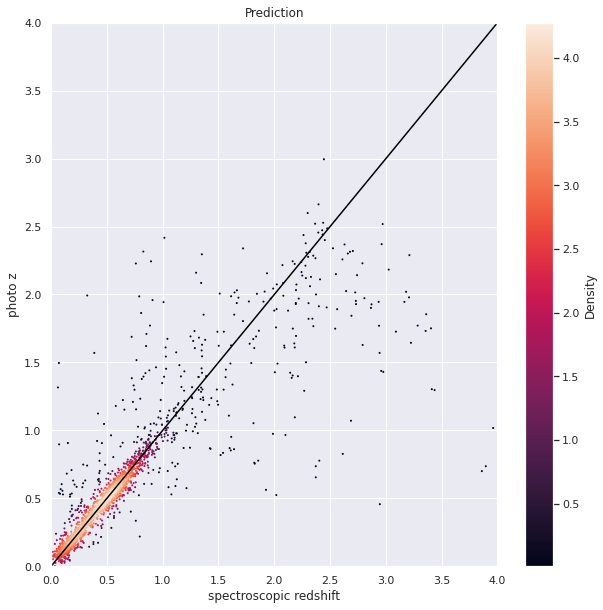

In [24]:
import seaborn as sns
z_max = 4
sns.set(rc = {'figure.figsize': (10, 10), 'lines.markersize': 20})
plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(specz, photoz, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max], color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

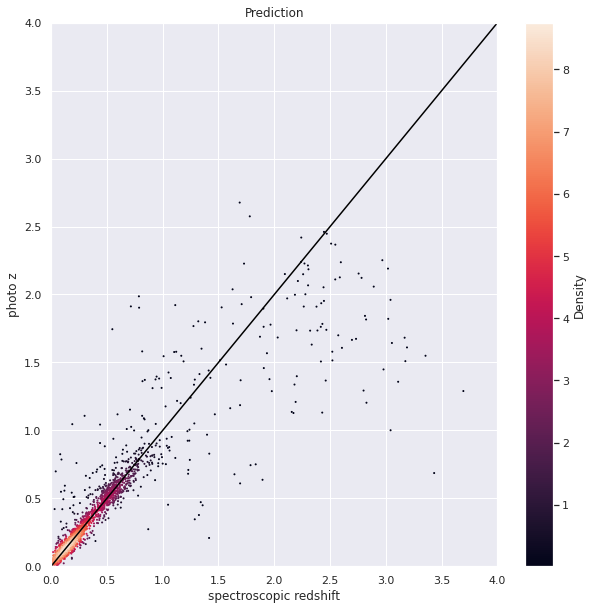

In [25]:
fig, ax = plt.subplots()
scatter_plot = ax.scatter(specz_2, photoz_2, c = z_2, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max], color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

sns.set(rc={'figure.figsize':(10, 10), 'lines.markersize':20})
plt.rcParams.update({'font.size': 100})
sns.set(font_scale=3)

data = {'BCNN':10.7, 'BNN':19.7, 'Mizuki':27.4,
        'DEmP':25}
models_list = list(data.keys())
outlier_rates = list(data.values())

plt.bar(models_list, outlier_rates, color=('blue', 'red', 'red', 'red'))
plt.plot([-.5, 3.5], [15, 15], color = 'black', linestyle = 'dashed')
plt.title("Outlier Rates")
plt.ylabel("% Outlier Rate")
plt.xlabel("Model Type")
plt.show()

In [26]:
overlap = 0
overlap_array = []
for i in range(0,t):
    if np.abs(specz[i]-photoz[i])<=photoz_err[i]:
        overlap += 1
        overlap_array.append(1)
    else:
        overlap_array.append(0)

In [27]:
overlap_2 = 0
overlap_array_2 = []
for i in range(0,t):
    if np.abs(specz_2[i]-photoz_2[i])<=photoz_err[i]:
        overlap_2 += 1
        overlap_array_2.append(1)
    else:
        overlap_array_2.append(0)

Coverage: 0.3915


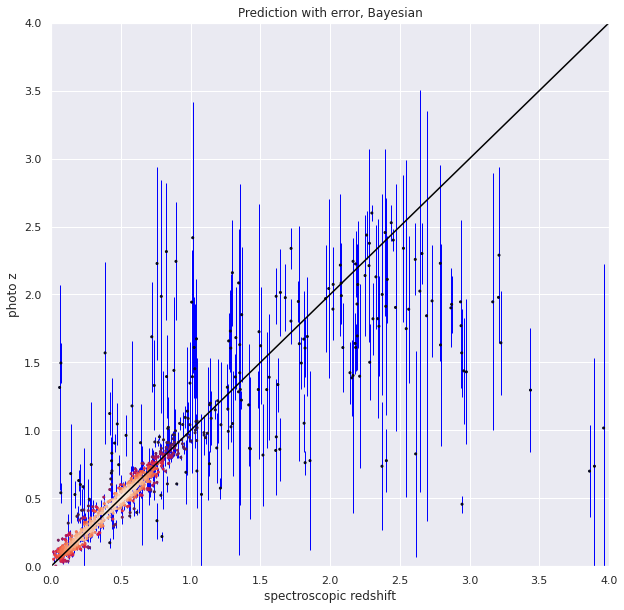

In [28]:
fig, ax = plt.subplots()
display_size = 1000
scatter_plot = ax.scatter(specz[:display_size], photoz[:display_size], c = z[:display_size], s = 4, edgecolor = None, zorder = 2)
error_plot = ax.errorbar(specz[:display_size], photoz[:display_size], yerr = photoz_err[:display_size], fmt = "o", markersize = 0, color = 'blue', elinewidth = 1, zorder = 1)
plt.title('Prediction with error, Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max], color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
print("Coverage: "+str(overlap_2/t))

In [29]:
combined_array = np.transpose(np.vstack((specz, photoz, photoz_err, overlap_array))) 
combined_array_2 = np.transpose(np.vstack((specz_2, photoz_2, photoz_err_2, overlap_array_2)))

In [30]:
sorted_combined_array = sorted(combined_array, key=lambda x: x[0])
sorted_combined_array_2 = sorted(combined_array_2, key=lambda x: x[0])

In [31]:
bins = int(z_max*5)
splitted_sorted_combined_array = np.array_split(sorted_combined_array, bins)
coverage = []
for i in range(0, bins):
    bins_count = 0
    for j in range(0,len(splitted_sorted_combined_array[i])):
        if splitted_sorted_combined_array[i][j][3] == 1:
            bins_count += 1
    coverage.append(bins_count/len(splitted_sorted_combined_array[i])/0.6827)

In [32]:
bins_2 = int(z_max*5)
splitted_sorted_combined_array_2 = np.array_split(sorted_combined_array_2, bins_2)
coverage_2 = []
for i in range(0, bins_2):
    bins_count_2 = 0
    for j in range(0,len(splitted_sorted_combined_array_2[i])):
        if splitted_sorted_combined_array_2[i][j][3] == 1:
            bins_count_2 += 1
    coverage_2.append(bins_count_2/len(splitted_sorted_combined_array_2[i])/0.6827)
x_array = np.arange(0, z_max, z_max/bins_2)

Filtered Coverage: 0.2885
Coverage: 0.3915


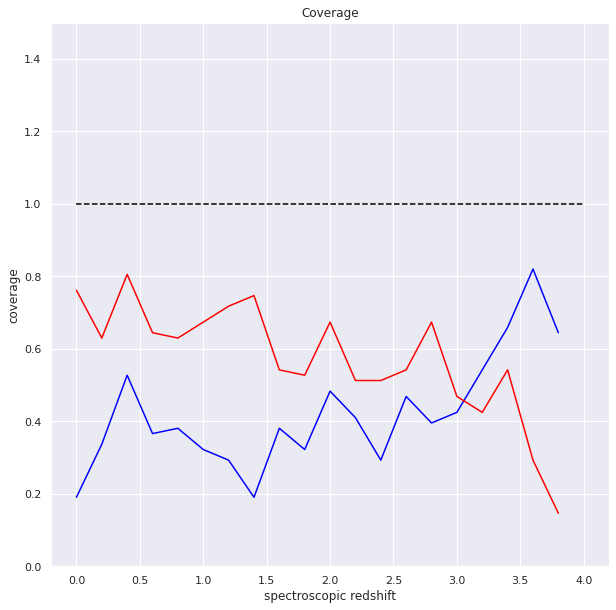

In [33]:
plt.plot(x_array, coverage, c = 'blue')
plt.plot(x_array, coverage_2, c = 'red')
plt.title('Coverage')
plt.xlabel('spectroscopic redshift')
plt.ylabel('coverage')
plt.ylim([0, 1.5])
plt.plot([0, 4], [1, 1], color = 'black', linestyle = 'dashed')
print("Filtered Coverage: "+str(overlap/t))
print("Coverage: "+str(overlap_2/t))

In [34]:
mean_array = []
for i in range(0, bins):
    total = 0
    for j in range(0, len(splitted_sorted_combined_array[i])):
        bias = (splitted_sorted_combined_array[i][j][1]-splitted_sorted_combined_array[i][j][0])/(1 + splitted_sorted_combined_array[i][j][0])
        total += bias/(1 + splitted_sorted_combined_array[i][j][0])
    mean_array.append(total/len(splitted_sorted_combined_array[i]))
x_array = np.arange(0, z_max, z_max/bins)

In [35]:
mean_array_2 = []
for i in range(0, bins_2):
    total_2 = 0
    for j in range(0, len(splitted_sorted_combined_array_2[i])):
        bias_2 = (splitted_sorted_combined_array_2[i][j][1]-splitted_sorted_combined_array_2[i][j][0])/(1 + splitted_sorted_combined_array_2[i][j][0])
        total_2 += bias_2/(1 + splitted_sorted_combined_array_2[i][j][0])
    mean_array_2.append(total_2/len(splitted_sorted_combined_array_2[i]))

In [36]:
error_array = []
for i in range(0,bins):
    error_total = 0
    for j in range(0,len(splitted_sorted_combined_array[i])):
        error_total += splitted_sorted_combined_array[i][j][2]
    error_array.append(error_total/len(splitted_sorted_combined_array[i]))

In [37]:
error_array_2 = []
for i in range(0,bins_2):
    error_total_2 = 0
    for j in range(0,len(splitted_sorted_combined_array_2[i])):
        error_total_2 += splitted_sorted_combined_array_2[i][j][2]
    error_array_2.append(error_total_2/len(splitted_sorted_combined_array_2[i]))

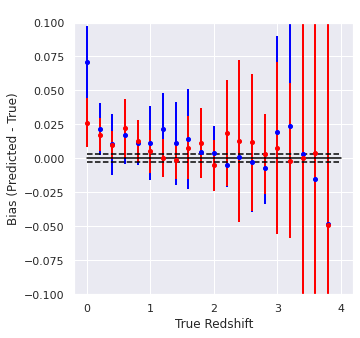

In [38]:
sns.set(rc={'figure.figsize':(5, 5), 'lines.markersize':40})
plt.rcParams.update({'font.size': 40})
plt.errorbar(x_array, mean_array, yerr = error_array, fmt = "o", color = 'blue', markersize = 4, elinewidth = 2)
plt.errorbar(x_array, mean_array_2, yerr = error_array_2, fmt = "o", color = 'red', markersize = 4, elinewidth = 2)
plt.title(' ')
plt.xlabel('True Redshift')
plt.ylabel('Bias (Predicted - True)')
plt.plot([0, z_max], [0, 0], color = 'black')
plt.plot([0, z_max], [0.003, 0.003], color = 'black', linestyle = 'dashed')
plt.plot([0, z_max], [-0.003, -0.003], color = 'black', linestyle = 'dashed')
plt.ylim([-0.1, 0.1])
plt.show()

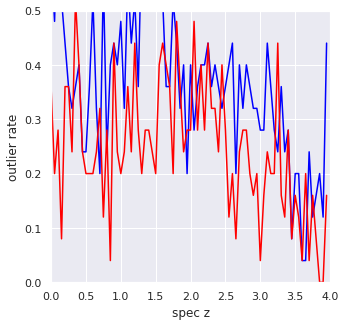

Outlier Rate Filtered: 0.364
Outlier Rate: 0.2475


In [39]:
combined_outlier_array_2 = np.transpose(np.vstack((specz_2, photoz_2, photoz_err_2)))
sorted_combined_outlier_array_2 = sorted(combined_outlier_array_2, key = lambda x: x[0])
bins_outlier = int(z_max * 20)
splitted_sorted_combined_outlier_array_2 = np.array_split(sorted_combined_outlier_array_2, bins_outlier)
outlier_array_2 = []
outlier_count_total_2 = 0
for i in range(0, bins_outlier):
    outlier_count_2 = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array_2[i])):
        if np.abs(splitted_sorted_combined_outlier_array_2[i][j][1] - splitted_sorted_combined_outlier_array_2[i][j][0]) >= 3 * splitted_sorted_combined_outlier_array_2[i][j][2]:
            outlier_count_2 += 1
            outlier_count_total_2 += 1
    outlier_array_2.append(outlier_count_2 / len(specz) * bins_outlier)

combined_outlier_array = np.transpose(np.vstack((specz, photoz, photoz_err)))
sorted_combined_outlier_array = sorted(combined_outlier_array, key = lambda x: x[0])
splitted_sorted_combined_outlier_array = np.array_split(sorted_combined_outlier_array, bins_outlier)
outlier_array = []
outlier_count_total = 0
for i in range(0, bins_outlier):
    outlier_count = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array[i])):
        if np.abs(splitted_sorted_combined_outlier_array[i][j][1] - splitted_sorted_combined_outlier_array[i][j][0]) >= 3 * splitted_sorted_combined_outlier_array[i][j][2]:
            outlier_count += 1
            outlier_count_total += 1
    outlier_array.append(outlier_count / len(specz) * bins_outlier)

x_array_outlier = np.arange(0, z_max, z_max / bins_outlier)
plt.plot(x_array_outlier, outlier_array, c = 'blue')
plt.plot(x_array_outlier, outlier_array_2, c = 'red')
plt.title('')
plt.xlabel('spec z')
plt.ylabel('outlier rate')
plt.xlim([0, z_max])
plt.ylim([0, 1 / 2])
plt.show()

print("Outlier Rate Filtered: "+str(outlier_count_total/len(specz)))
print("Outlier Rate: "+str(outlier_count_total_2/len(specz)))

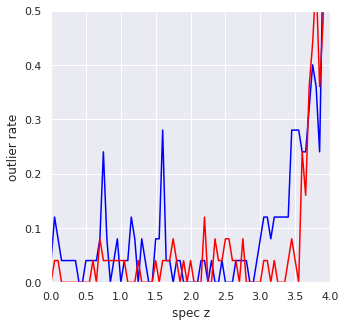

Outlier Rate Filtered: 0.0955
Outlier Rate: 0.0665


In [40]:
combined_outlier_array = np.transpose(np.vstack((specz, np.subtract(photoz, specz))))
sorted_combined_outlier_array = sorted(combined_outlier_array, key = lambda x: x[0])
splitted_sorted_combined_outlier_array = np.array_split(sorted_combined_outlier_array, bins_outlier)
outlier_array = []
outlier_count_total = 0
for i in range(0, bins_outlier):
    outlier_count = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array[i])):
        if np.abs(splitted_sorted_combined_outlier_array[i][j][1] / (splitted_sorted_combined_outlier_array[i][j][0] + 1)) >= .15:
            outlier_count += 1
            outlier_count_total += 1
    outlier_array.append(outlier_count / len(specz) * bins_outlier)

combined_outlier_array_2 = np.transpose(np.vstack((specz_2, np.subtract(photoz_2, specz_2))))
sorted_combined_outlier_array_2 = sorted(combined_outlier_array_2, key = lambda x: x[0])
splitted_sorted_combined_outlier_array_2 = np.array_split(sorted_combined_outlier_array_2, bins_outlier)
outlier_array_2 = []
outlier_count_total_2 = 0
for i in range(0, bins_outlier):
    outlier_count_2 = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array_2[i])):
        if np.abs(splitted_sorted_combined_outlier_array_2[i][j][1] / (splitted_sorted_combined_outlier_array_2[i][j][0] + 1)) >= .15:
            outlier_count_2 += 1
            outlier_count_total_2 += 1
    outlier_array_2.append(outlier_count_2 / len(specz_2) * bins_outlier)

plt.plot(x_array_outlier, outlier_array, c = 'blue')
plt.plot(x_array_outlier, outlier_array_2, c = 'red')

plt.title('')
plt.xlabel('spec z')
plt.ylabel('outlier rate')
plt.xlim([0,z_max])
plt.ylim([0,1/2])
plt.show()

print("Outlier Rate Filtered: "+str(outlier_count_total/len(specz)))
print("Outlier Rate: "+str(outlier_count_total_2/len(specz)))

uncertains = []
for i in range(0, len(photoz_err)):
    if photoz_err[i].numpy() >= 1:
        uncertains.append(i)
        print("Object ID: " + str(object_id[i]) + ", Spectro_z: " + str(specz[i]) + ", Photo_z: " + str(photoz[i]) + ", Photo_z_err: " + str(photoz_err[i].numpy()))

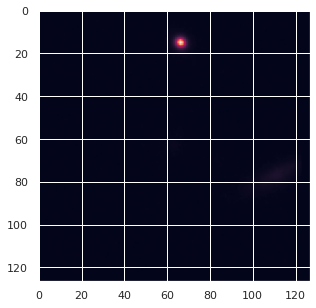

In [41]:
plt.imshow(x_train_2[9][:,:,0])

check = 2
current = uncertains[check]
print("Object ID: " + str(object_id[current]) + ", Spectro_z: " + str(specz[current]) + ", Photo_z: " + str(photoz[current]) + ", Photo_z_err: " + str(photoz_err[current].numpy()))
plt.imshow(x_test[current][:,:,0])
plt.grid(False)

biases = []
for i in range(0, len(photoz)):
    if np.abs(photoz[i]-specz[i]) >= 1 and photoz_err[i].numpy() <= 0.5:
        biases.append(i)
        print("Object ID: " + str(object_id[i]) + ", Spectro_z: " + str(specz[i]) + ", Photo_z: " + str(photoz[i]) + ", Photo_z_err: " + str(photoz_err[i].numpy()))

check_bias = 3
current_bias = biases[check_bias]
print("Object ID: " + str(object_id[current_bias]) + ", Spectro_z: " + str(specz[current_bias]) + ", Photo_z: " + str(photoz[current_bias]) + ", Photo_z_err: " + str(photoz_err[current_bias].numpy()))
plt.imshow(x_test[current_bias][:,:,0])
plt.grid(False)

In [42]:
# END